<a href="https://colab.research.google.com/github/nielsvogell/road-extraction/blob/main/gaussian_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helpers

In [1]:
# Imports
import cv2
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import copy
from PIL import Image
from enum import Enum  
from scipy import spatial
from sklearn.mixture import GaussianMixture

In [2]:
def plotImages(images, r, c, cmap=None, title=None):
  if not title == None: plt.title(title)
  for index, image in enumerate(images):
    plt.subplot(r, c, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=cmap)
    #plt.tight_layout()
  plt.tight_layout()

In [3]:
def HSV2RGB(img_hsv):
  return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

def BGR2RGB(img_bgr):
  return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Give every pixel the label

# optional: show_color_evaluation
- input image path
- plots image and colors with labels as title

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


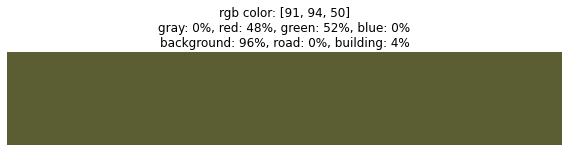

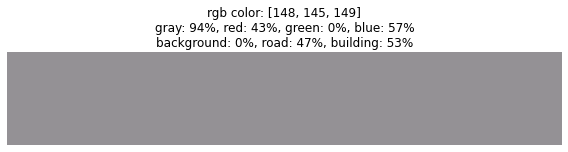

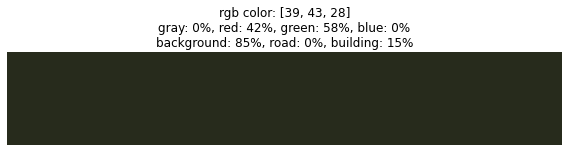

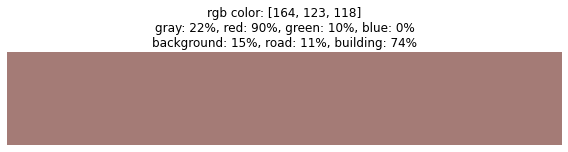

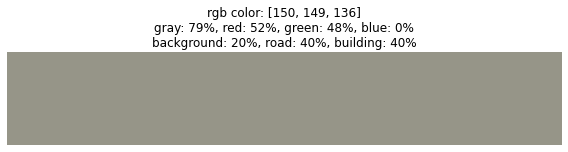

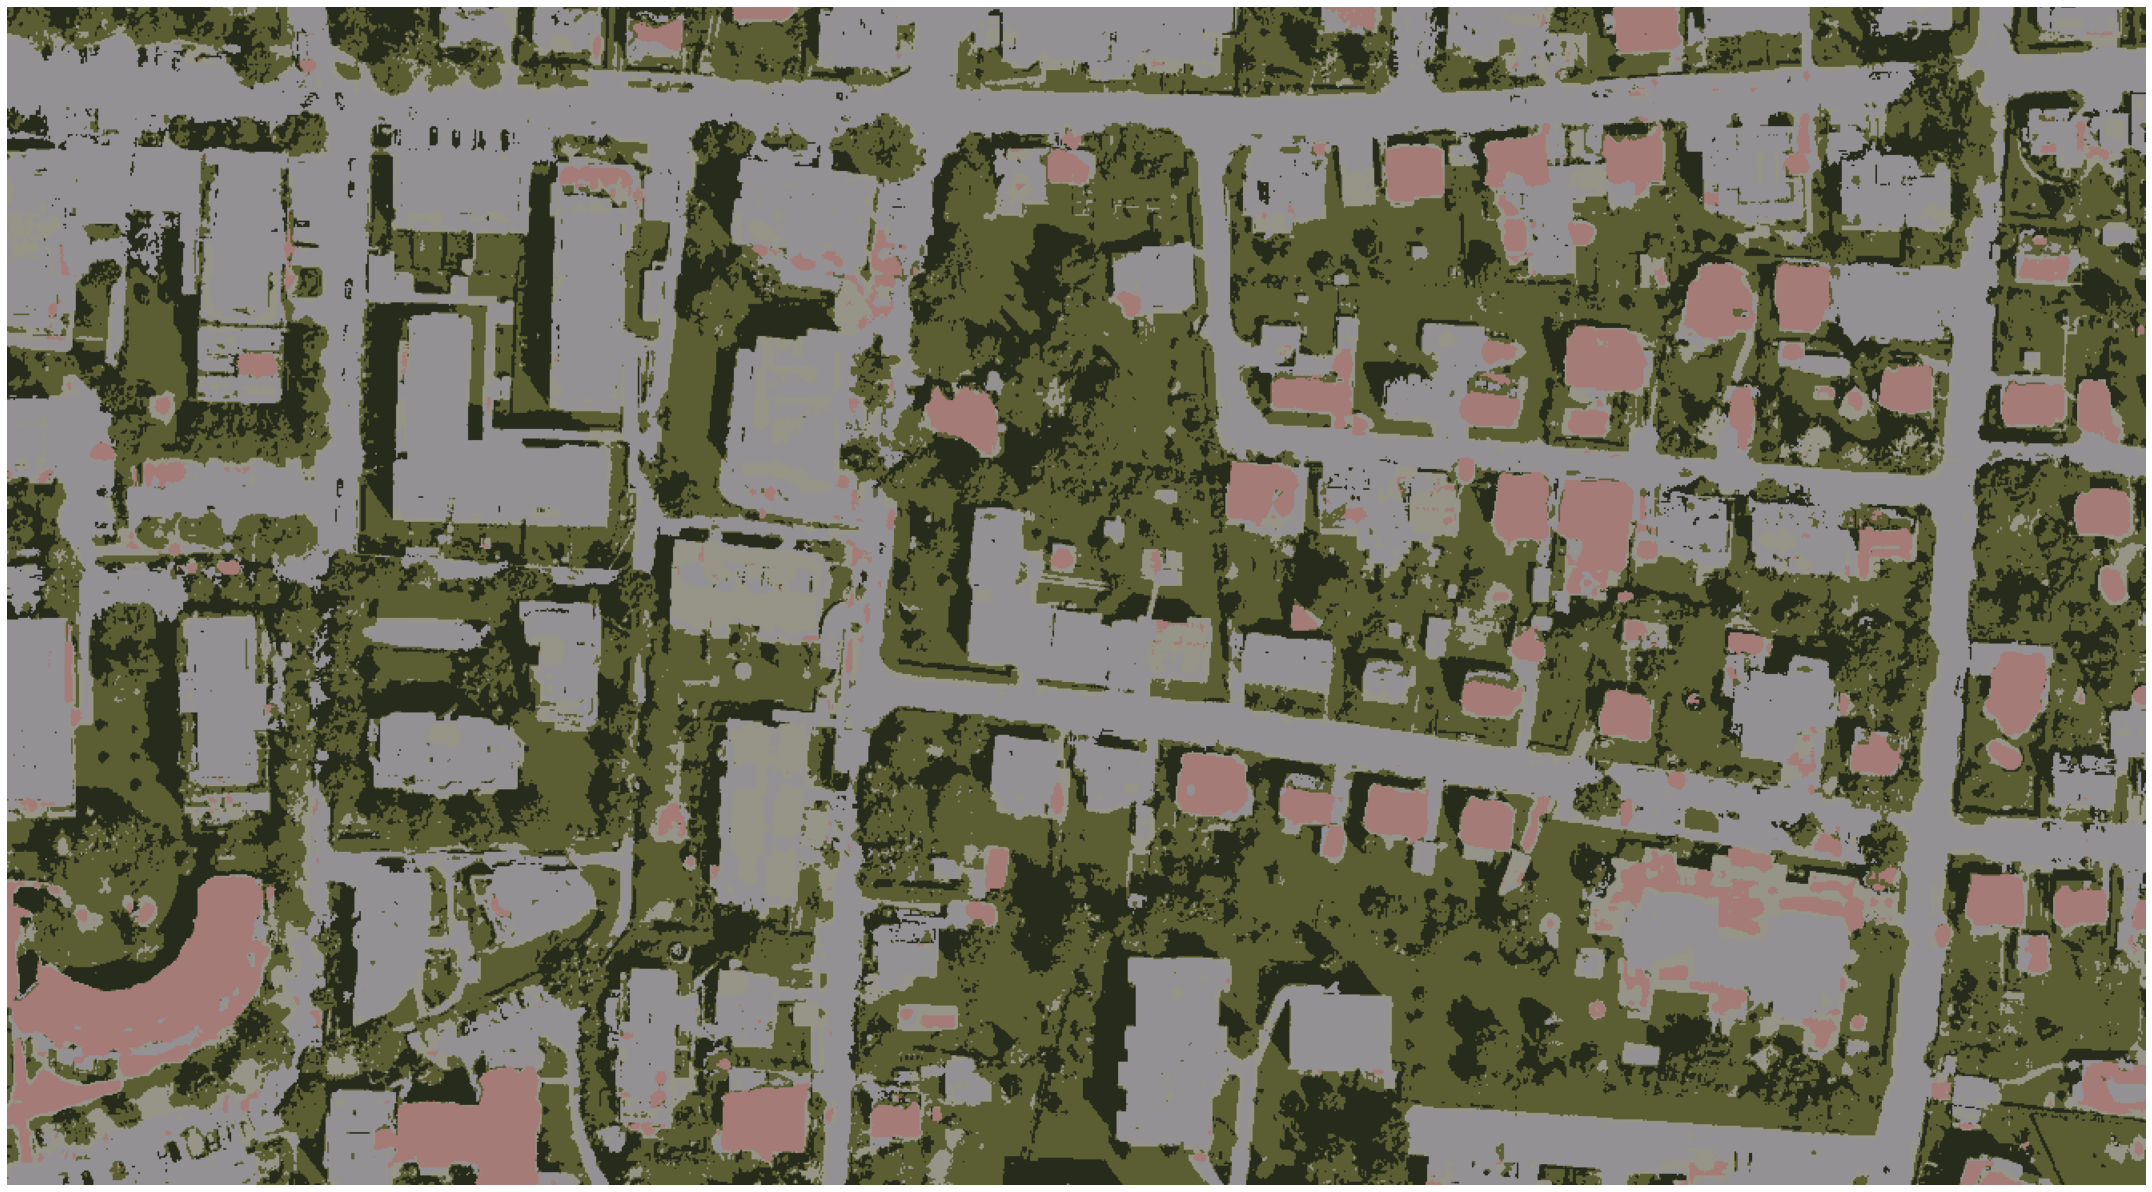

In [ ]:
path = "klagenfurt1.png"
show_color_evaluation(path)

In [ ]:
def show_color_evaluation(path):
  img = cv2.imread("/content/drive/MyDrive/ImageProcessingProject/images/" + path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Cluster
  labels, cluster_colors = cluster_image_colors(img_rgb, nr_clusters=5)
  
  for color in cluster_colors.values():
    # Evaluate Color
    evaluation, gray, red, green, blue = evaluate_color(color)

    title_rgb = "rgb color: {}\n".format(color)
    title_colors = "gray: {}%, red: {}%, green: {}%, blue: {}%\n".format(round(gray), round(red), round(green), round(blue))
    title_labels = "background: {}%, road: {}%, building: {}%".format(round(evaluation['background']), round(evaluation['road']), round(evaluation['building']))

    color_swatch_img = [[color, color, color, color, color, color]]

    plt.figure(figsize = (8, 8))
    plotImages([color_swatch_img], 1, 1, title=title_rgb+title_colors+title_labels)

  # copy img and change value of each pixel to the median value of its cluster
  img_gm = copy.deepcopy(img_rgb)
  index = 0
  for x in range(len(img_gm)):
    for y in range(len(img_gm[x])):
      img_gm[x, y] = cluster_colors[labels[index]]
      index += 1
  plt.figure(figsize = (30, 30))
  plotImages([img_gm], 1, 1)


# cluster_image_colors (Gaussian Mixture)
- inpu img_rgb
- input nr_clusters
- returns labels array of cluster_labels for each pixel
- returns cluster_colors array of the cluster_colors for each label  

In [ ]:
def cluster_image_colors(img_rgb, nr_clusters):
  all_colors = [values for x in img_rgb.tolist() for values in x]
  labels, cluster_colors = gaussian_mixture_cluster(all_colors, nr_clusters)
  return labels, cluster_colors

def gaussian_mixture_cluster(X, nr_clusters, print=False, print_all_values=False):
  X = np.array(X)
  
  # Cluster with Gaussian Mixture
  gm = GaussianMixture(n_components=nr_clusters, random_state=0).fit(X)
  labels = gm.predict(X)
  
  unique_labels = np.unique(labels)
  n_clusters_ = len(unique_labels)

  # Calculate Median Value for each Cluster
  cluster_colors = {}

  if print: print("There are {} clusters!".format(n_clusters_))

  for k in unique_labels:
    my_members = labels == k
    if print: print("Label: {}".format(k))

    cluster_median_value = [0] * (len(X[0]))
    nr_points = 0

    for in_cluster, index in zip(my_members, range(len(my_members))):
      if in_cluster:
        if print_all_values: print("\t{}".format(X[index]))
        nr_points += 1
        cluster_median_value = [x + y for x, y in zip(X[index], cluster_median_value)]

    cluster_colors[k] = [round(x/nr_points) for x in cluster_median_value]
    if print: print("Color: {}\n".format(cluster_colors[k]))
      
  return labels, cluster_colors

# evaluate_color (Assign building, road, background label percentage to every color)
- input color
- returns dict of background, road, building

In [ ]:
# returns building/background/road based on color assignment with "percent_gray_red_green_blue"
def evaluate_color(color_rgb):
  gray = is_gray(color_rgb, min(color_rgb)/2)
  red, green, blue = is_red_green_blue(color_rgb)

  # gray -> road or building
  # green and red similar -> background

  background = (1 - (abs(red-green) / (red+green))) * 100
  not_background = (100-background)

  not_gray = (100-gray)/100

  mapType = {'background': background*not_gray, 'road': gray/2, 'building': not_background*not_gray + gray/2}
  
  return mapType, gray, red, green, blue

# returns percentage on how gray
# based on grayish rgb colors have similar values for r, g, b
def is_gray(color_rgb, diff_range=100):
  r, g, b = color_rgb
  diffs = abs(r-g), abs(r-b), abs(g-b)
  max_diff = max(diffs)
  gray_percentage = (1 - (max_diff / diff_range)) * 100
  return 0 if gray_percentage < 0 else gray_percentage

# returns array r, g, b of 0-100 percentage
# based on the r, g, b with the highest values and their diff to lower values
def is_red_green_blue(color_rgb, d=0):
  r, g, b = color_rgb

  # substract half max value 
  # -> if lower value less than half of max value -> its too minimal to change color
  max_value = max([r, g, b])
  max_diff = int(max_value / 2)
  r, g, b = [(x - max_diff if x > max_diff else 0) for x in [r, g, b]]
  
  # substract min value 
  # -> if the lower two values are similar it just grays the first color and doesn't change it
  min_value = min([r, g, b])
  r, g, b = [(x - min_value) for x in [r, g, b]]

  sum_value = r + g + b
  r, g, b = [(x/sum_value) * 100 if x > 0 else x for x in [r, g, b]]

  return [r, g, b]